# 1D ETDRK4

Import libraries and modules.

In [160]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import integrate
import utils
import checker
%matplotlib inline

The ETDRK4 scheme in 1D.

In [144]:
def etdrk4_1d(Nx,Lx,dt,it,eps,sigma,m,seed,lv):
    x = Lx*np.linspace(1,Nx,Nx)/Nx
    
    np.random.seed(seed)
    r = np.random.uniform(-1.,1.,Nx)
    # zeroing the mean.
    if r.mean()<0:
        r -= r.mean()
    else:
        r += r.mean()

    # scale factor for randomness.
    C = 0.01
    u = m+C*r
    v = np.fft.fft(u)

    # generate wavenumbers
    tpiL = (2.*np.pi)/Lx
    k = 2.*np.pi*np.fft.fftfreq( Nx , (1.0 / float(Nx) ) ) / Lx

    L = -1. * eps**2 * k**4 * tpiL**4 + k**2 * tpiL**2 - sigma
    E = np.exp(dt*L)
    E2 = np.exp(dt*L/2)

    # shift in complex-plane.
    M = 16 # number of roots of unity
    r = np.exp(1j * np.pi * (np.linspace(1,M,M)-.5) / float(M))
    Lp = np.tile(L.reshape(-1,1), (1,M))
    rp = np.tile(r.reshape(1,-1), (Nx,1))
    LR = dt * Lp + rp
    F2u = -np.real(np.mean( dt * (1. - np.exp(LR/2.))/LR, axis=1))
    F2u[1:] = 0
    Fu = -np.real(np.mean( dt * (1. - np.exp(LR))/LR, axis=1))
    Fu[1:] = 0
    Q = np.real(np.mean( dt * (np.exp(LR/2) - 1.) / LR , axis=1))
    f1 = np.real(np.mean( dt * (-4. - LR + np.exp(LR) * (4.-3.*LR+LR**2)) / LR**3 , axis=1))
    f2 = np.real(np.mean( dt * (2. + LR + np.exp(LR) * (-2. + LR)) / LR**3 , axis=1))
    f3 = np.real(np.mean( dt * (-4. - 3. * LR - LR**2 + np.exp(LR) * (4. - LR)) / LR**3, axis=1))

    tic = time.time()
    
    # laplacian for nonlinear term
    g = -1. * k**2 * tpiL**2

    # create and get path to store arrays and diagrams
    imgDir = 'imgs/'
    tag = ',etdrk4_1D'
    path = utils.getPath(Nx,Lx,dt,it,eps,sigma,m,seed,lv,imgDir,tag)

    # take a snapshot of avg. conc and energy at every 10 iterations
    avgConc = np.zeros(it/10+1)
    energy = np.zeros(it/10+1)
    dx = np.linspace(0,Lx,Nx)

    # time-stepping
    j = 0
    for i in range(it+1):
        t = n * dt;
        Nv = g*np.fft.fft(np.fft.ifft(v)**3)
        a = E2 * v + Q * Nv + F2u * sigma * m * Nx
        Na = g*np.fft.fft(np.fft.ifft(a)**3)
        b = E2 * v + Q * Na + F2u * sigma * m * Nx
        Nb = g*np.fft.fft(np.fft.ifft(b)**3)
        c = E2 * a + Q * (2.*Nb-Nv) + F2u * sigma * m * Nx
        Nc = g*np.fft.fft(np.fft.ifft(c)**3)
        v = E * v + Nv * f1 + 2. * (Na+Nb) * f2 + Nc * f3 + Fu * sigma * m * Nx

        # at every lv-th iteration, capture morphology (as image and text array)
        if ( i % lv ) == 0:
            filename  = 'it='+str(i)
            fig1 = plt.figure(figsize=(5,3))

            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.plot(x,u)

            plt.savefig(path+'/'+filename+'.pdf')
            plt.close();

            u = np.real(np.fft.ifft(v))
            utils.outputArray(u,path,filename)

        # for every 10-iterations, capture the avg. conc and energy for error analysis
        if (i%10)==0:
            u = np.real(np.fft.ifft(v))
            avgConc[j] = utils.avgConc(u,dx,Lx,dim=1)
            energy[j] = utils.energyFunc(u,eps,sigma,m,dx,k,tpiL,dim=1)
            j += 1

    toc = time.time()
    print('time taken: %.4f' %(toc-tic))
    
    # as energy is unitless, rescale energy as a fraction of the initial energy.
    energy /= energy[0]
    
    u = np.real(np.fft.ifft(v))

    # save the average conc. and energy arrays.
    utils.outputArray(energy,path,'energy')
    utils.outputArray(avgConc,path,'avgConc')
    
    return u, avgConc, energy

The parameters for the numerical experiment. Iterate over different sigmas and seeds. The numerical experiment was conducted over 2 * 10 set of seeds, over 7 sigmas values.|

In [161]:
# set spatial and time intervals / grids
Nx = 128
Lx = 2.*np.pi
dt = 0.001

# setup initial conditions.
eps = 0.06
#sigma = 0.
m = 0.33

it = 400000 # number of iterations
lv = 2000 # iteration intervals to take snapshot of morphology
#seed = 555

t = np.arange(0,it/10+1)*dt*10

# first set of 10 seeds
seeds = [555,4379,7626,12883,17384,23057,24800,33688,40385,41277]
# second set of 10 seeds
seeds = [3076,17145,27193,32927,47329,62877,75313,81602,91403,100000]

sigmas = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030]

The iteration of the experiment over sigmas and seeds.

time taken: 213.6530
seed= 3076,sigma=0.0001


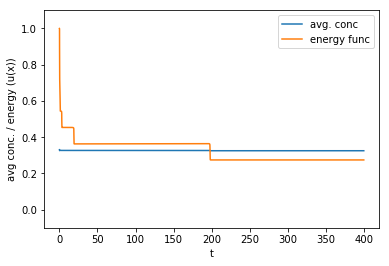

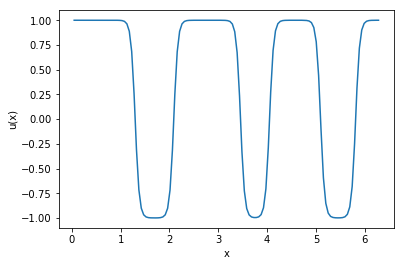

time taken: 181.2130
seed=17145,sigma=0.0001


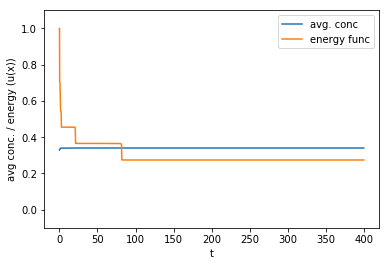

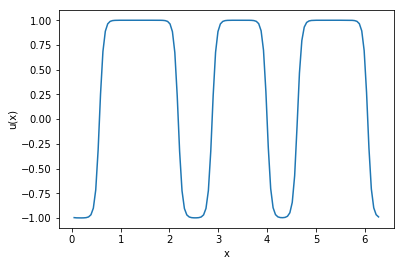

time taken: 172.2680
seed=27193,sigma=0.0001


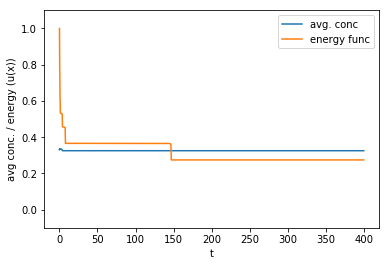

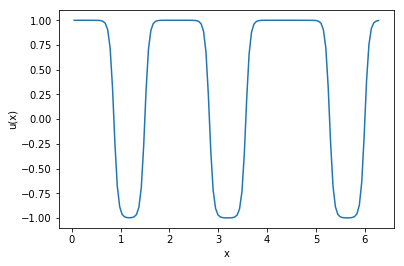

time taken: 169.0860
seed=32927,sigma=0.0001


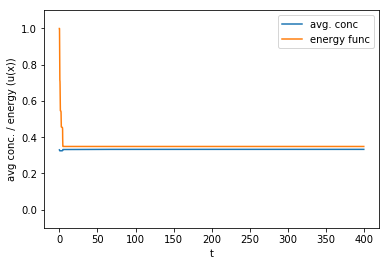

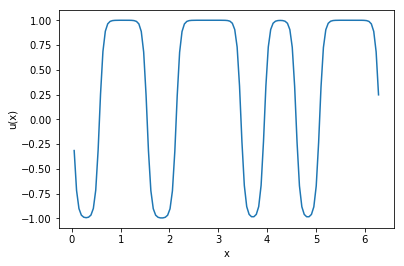

time taken: 168.5220
seed=47329,sigma=0.0001


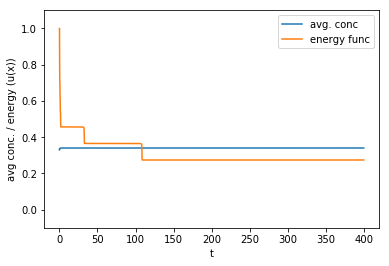

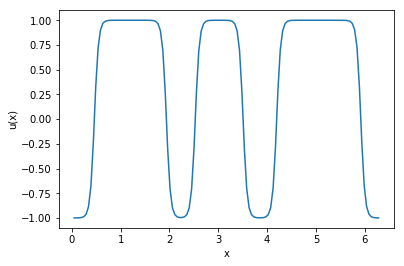

time taken: 173.8190
seed=62877,sigma=0.0001


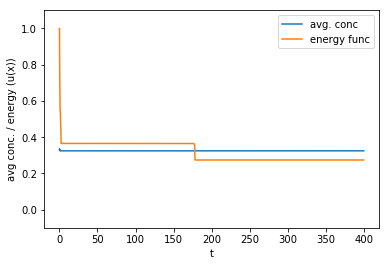

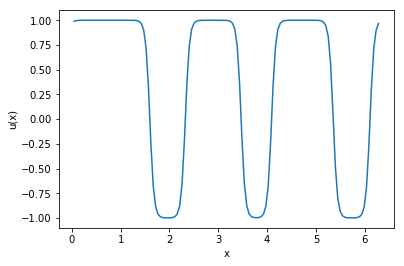

time taken: 171.1890
seed=75313,sigma=0.0001


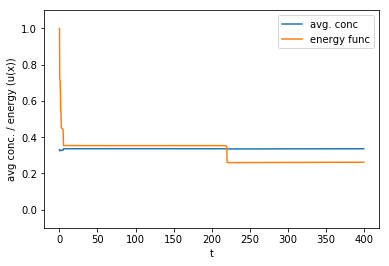

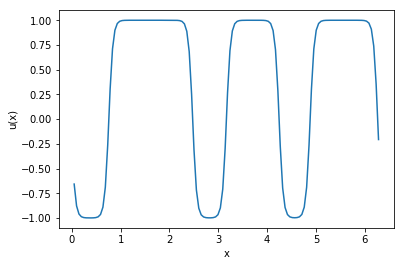

time taken: 171.2950
seed=81602,sigma=0.0001


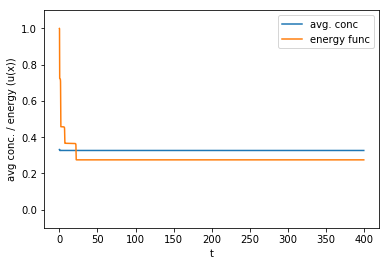

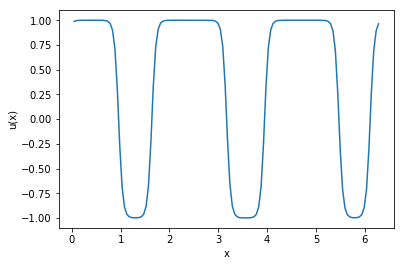

time taken: 170.4880
seed=91403,sigma=0.0001


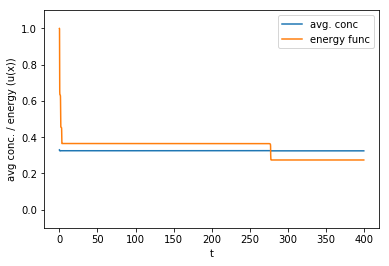

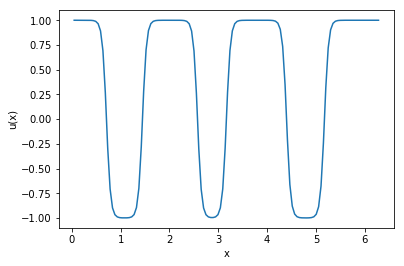

time taken: 170.3370
seed=100000,sigma=0.0001


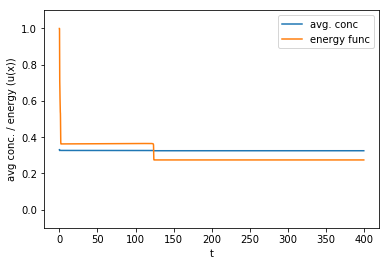

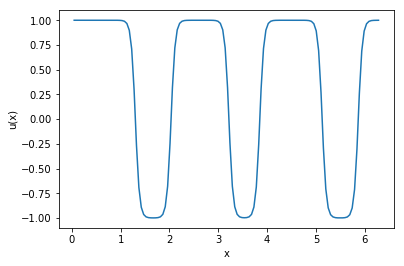

time taken: 173.6740
seed= 3076,sigma=0.0005


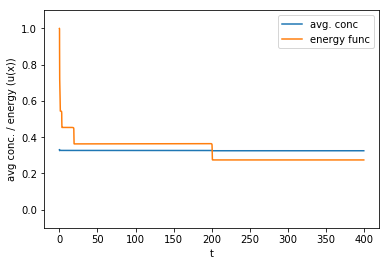

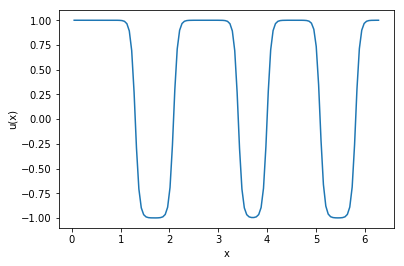

time taken: 167.3190
seed=17145,sigma=0.0005


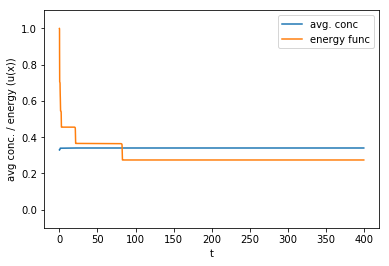

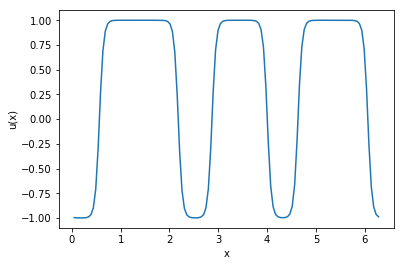

time taken: 171.1500
seed=27193,sigma=0.0005


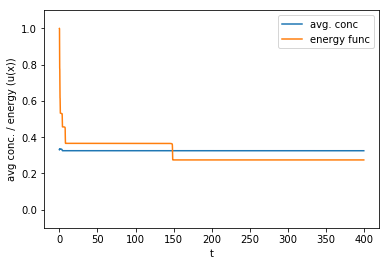

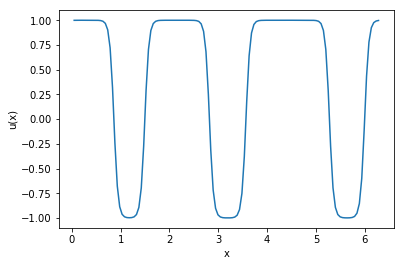

time taken: 169.4920
seed=32927,sigma=0.0005


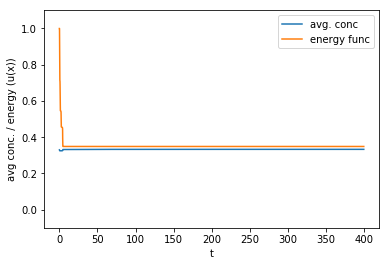

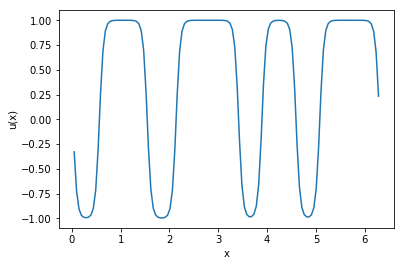

time taken: 169.5310
seed=47329,sigma=0.0005


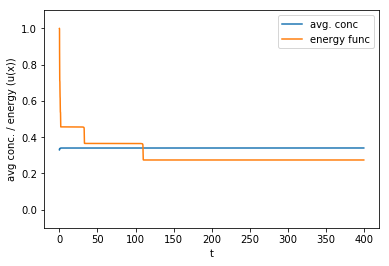

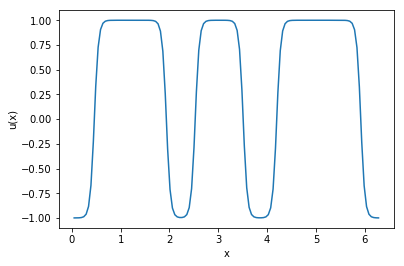

time taken: 170.2650
seed=62877,sigma=0.0005


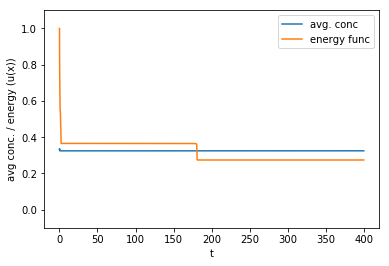

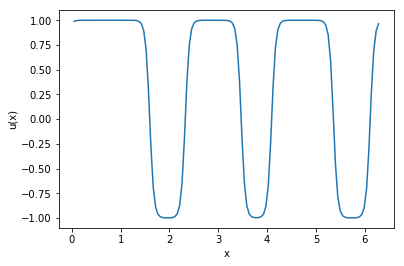

time taken: 168.2800
seed=75313,sigma=0.0005


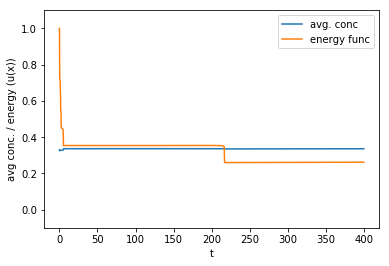

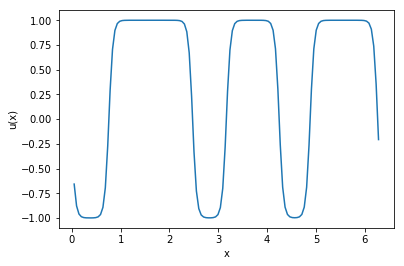

time taken: 171.5840
seed=81602,sigma=0.0005


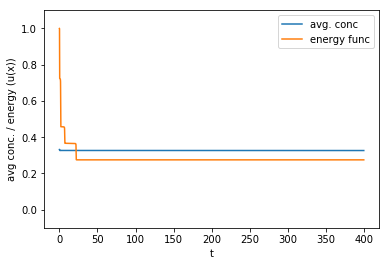

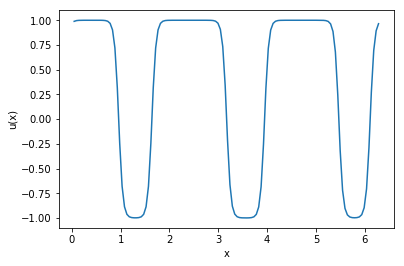

time taken: 167.3510
seed=91403,sigma=0.0005


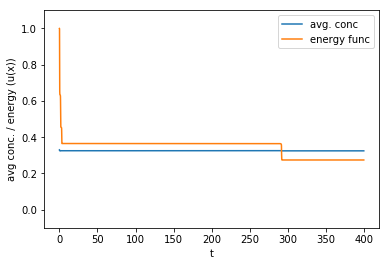

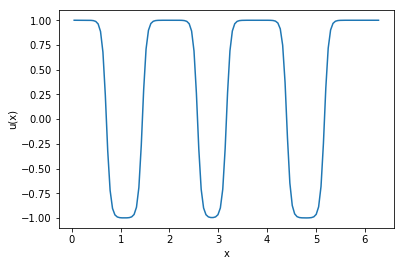

time taken: 171.2500
seed=100000,sigma=0.0005


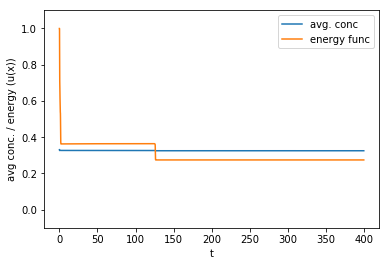

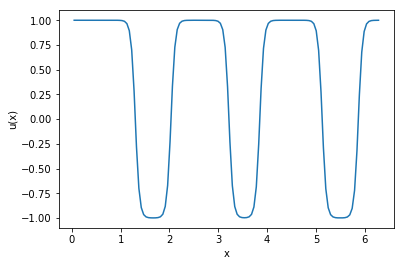

time taken: 171.0050
seed= 3076,sigma=0.0010


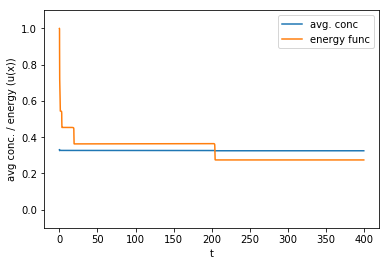

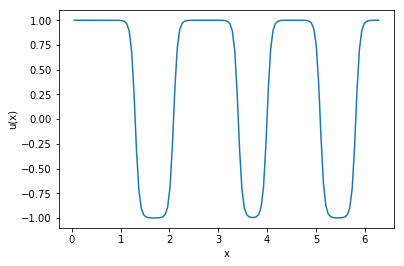

time taken: 167.9870
seed=17145,sigma=0.0010


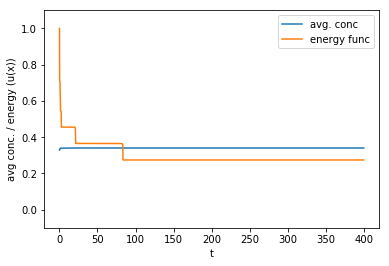

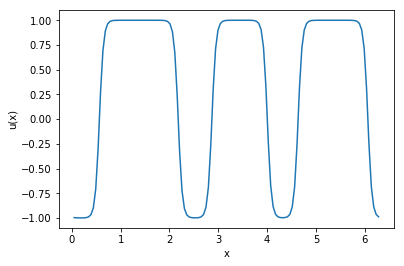

time taken: 174.0820
seed=27193,sigma=0.0010


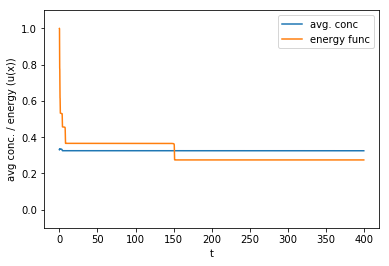

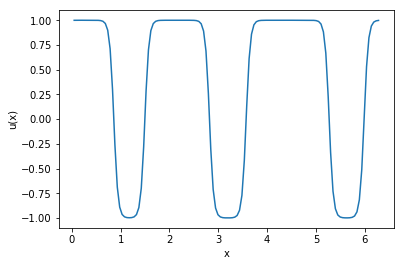

time taken: 166.7040
seed=32927,sigma=0.0010


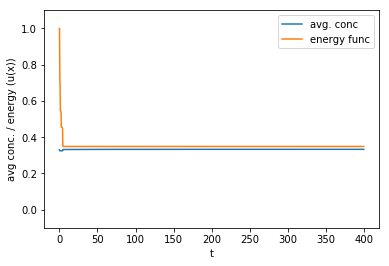

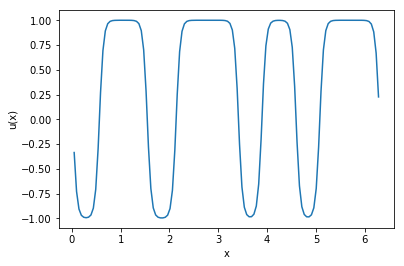

time taken: 172.9820
seed=47329,sigma=0.0010


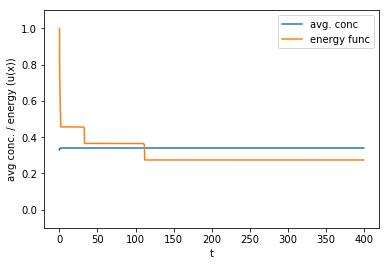

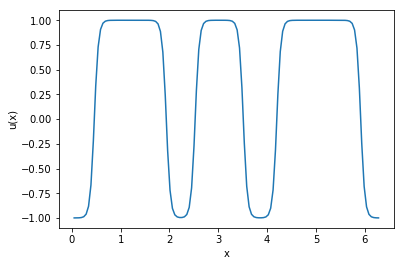

time taken: 169.6940
seed=62877,sigma=0.0010


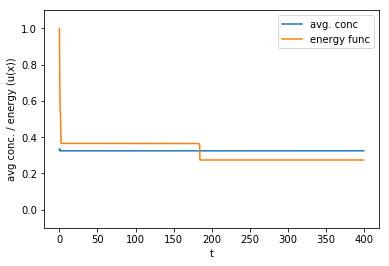

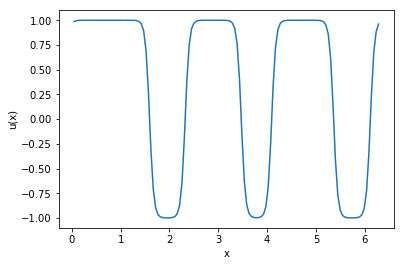

time taken: 168.4870
seed=75313,sigma=0.0010


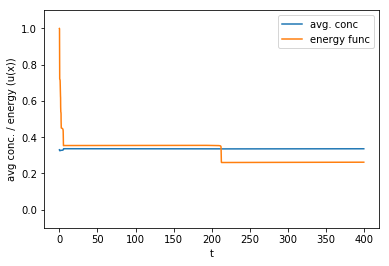

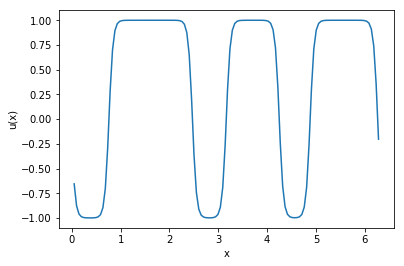

time taken: 167.4530
seed=81602,sigma=0.0010


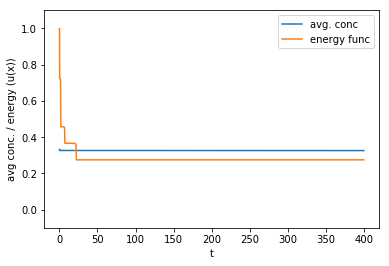

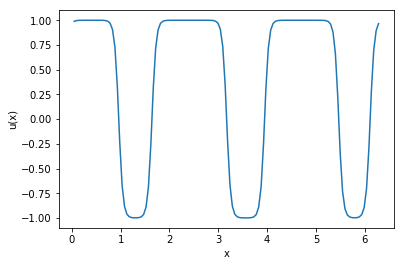

time taken: 168.0510
seed=91403,sigma=0.0010


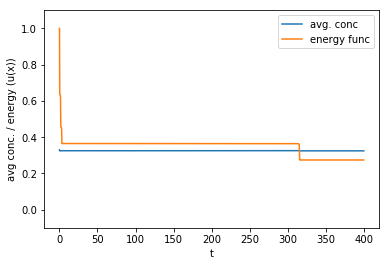

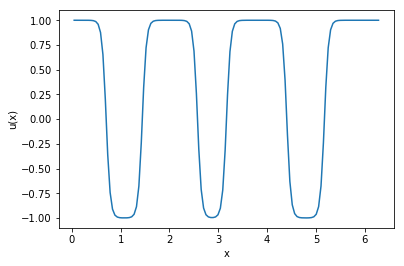

time taken: 172.1270
seed=100000,sigma=0.0010


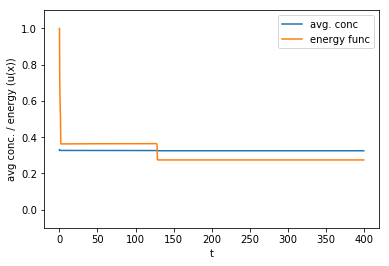

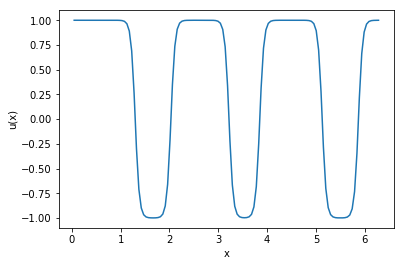

time taken: 166.9100
seed= 3076,sigma=0.0015


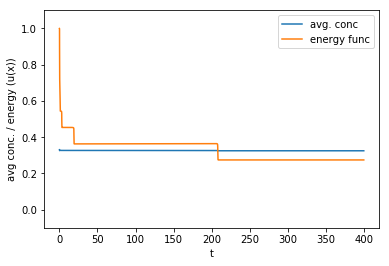

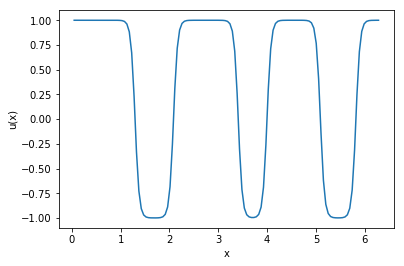

time taken: 171.7900
seed=17145,sigma=0.0015


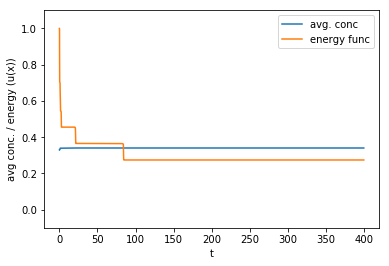

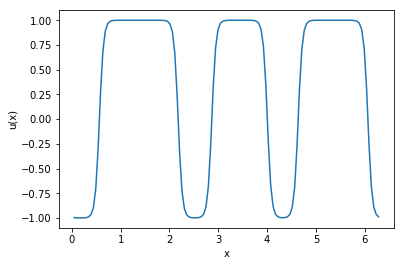

time taken: 167.1850
seed=27193,sigma=0.0015


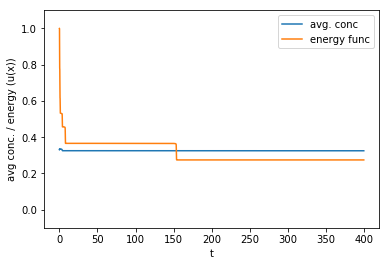

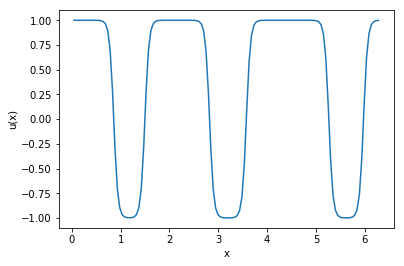

time taken: 169.8340
seed=32927,sigma=0.0015


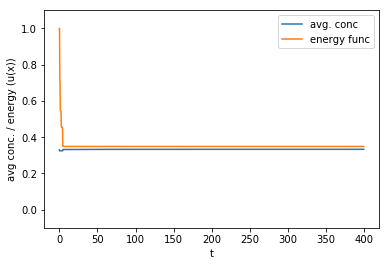

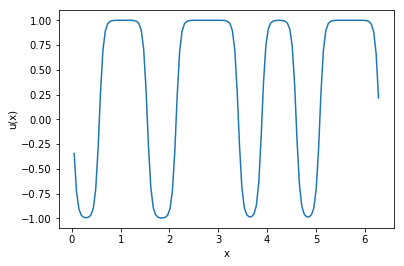

time taken: 170.0860
seed=47329,sigma=0.0015


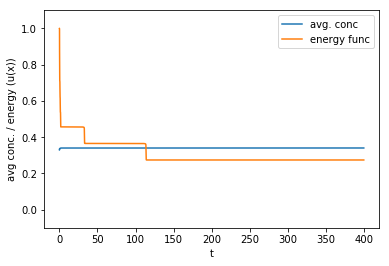

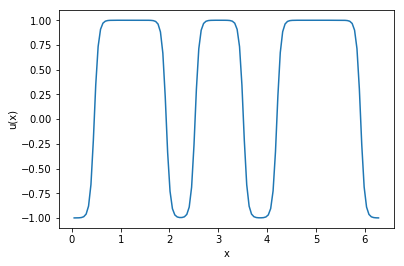

time taken: 166.6660
seed=62877,sigma=0.0015


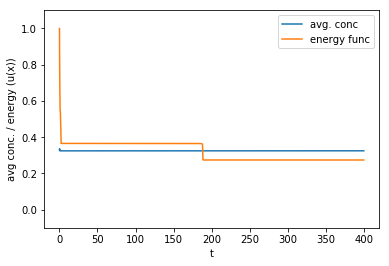

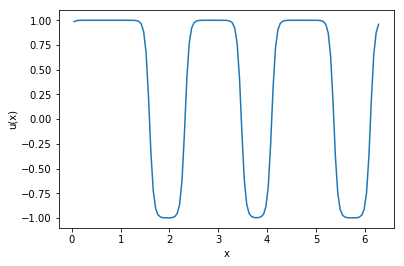

time taken: 171.8990
seed=75313,sigma=0.0015


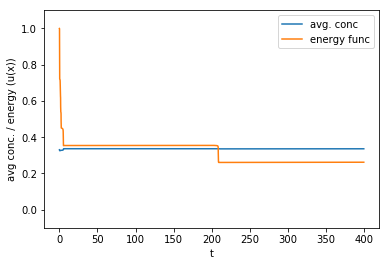

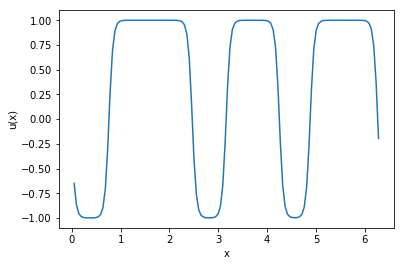

time taken: 169.7760
seed=81602,sigma=0.0015


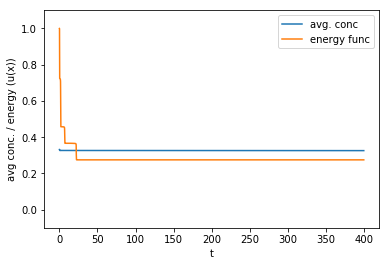

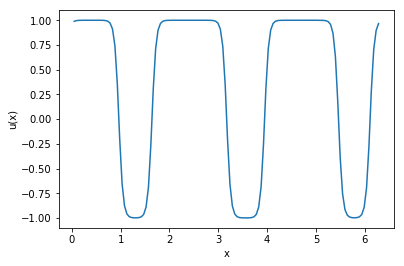

time taken: 169.8680
seed=91403,sigma=0.0015


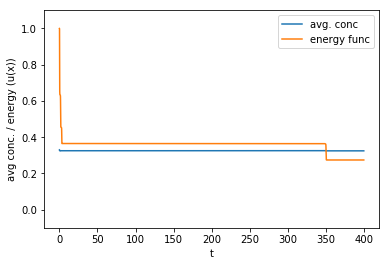

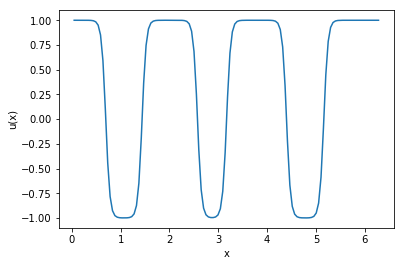

time taken: 170.1600
seed=100000,sigma=0.0015


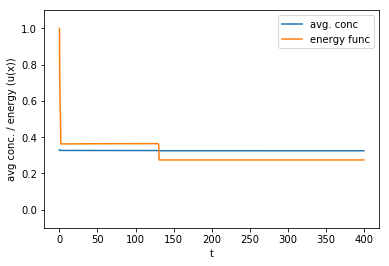

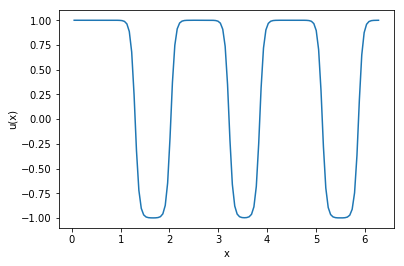

time taken: 164.5200
seed= 3076,sigma=0.0020


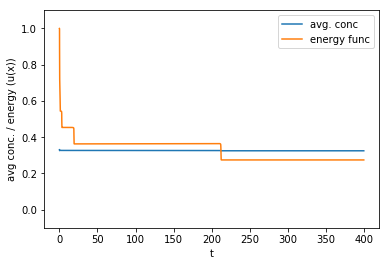

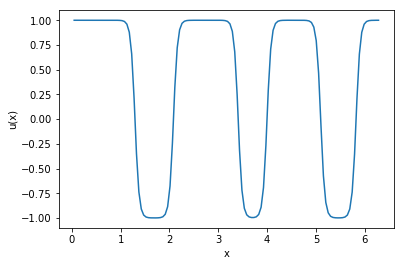

time taken: 171.9440
seed=17145,sigma=0.0020


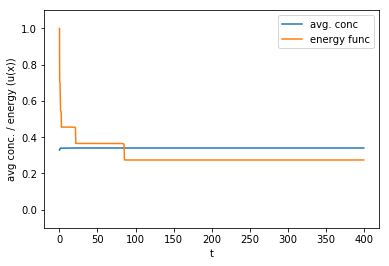

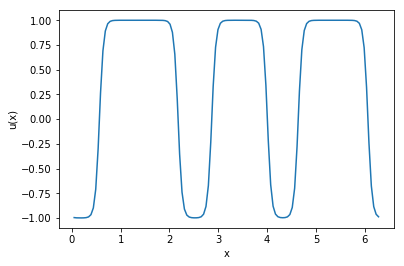

time taken: 167.9700
seed=27193,sigma=0.0020


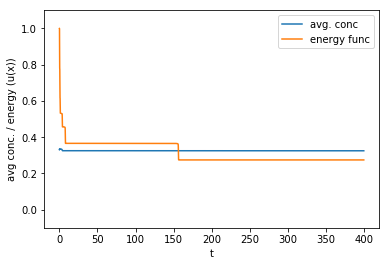

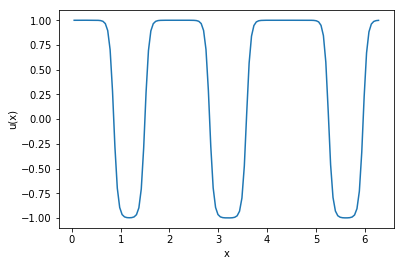

time taken: 171.0980
seed=32927,sigma=0.0020


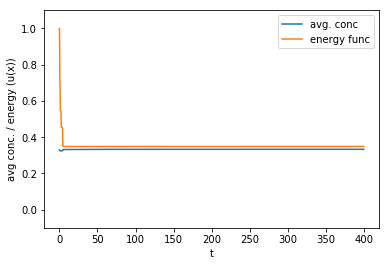

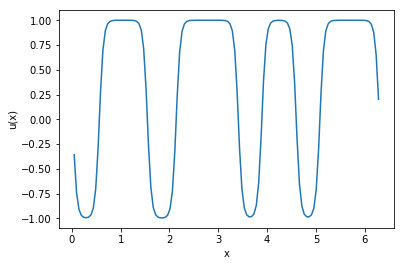

time taken: 170.9410
seed=47329,sigma=0.0020


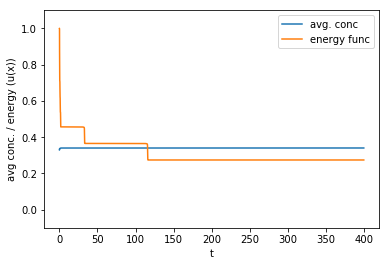

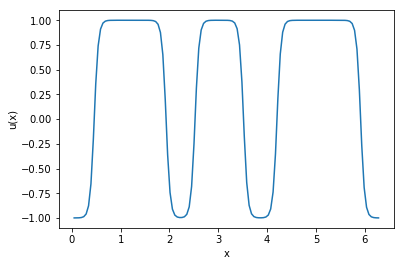

time taken: 168.5260
seed=62877,sigma=0.0020


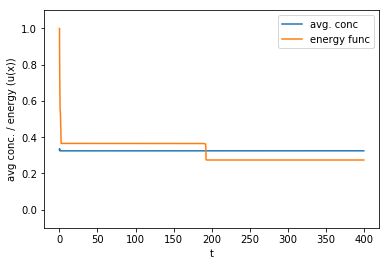

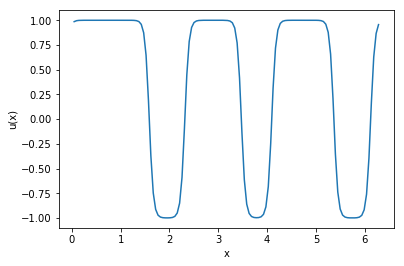

time taken: 167.3150
seed=75313,sigma=0.0020


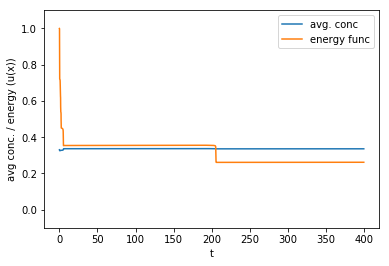

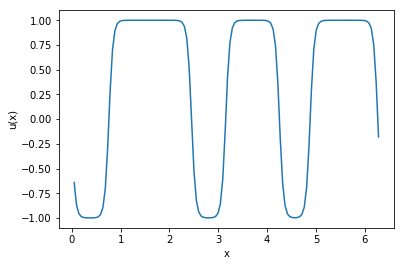

time taken: 169.1520
seed=81602,sigma=0.0020


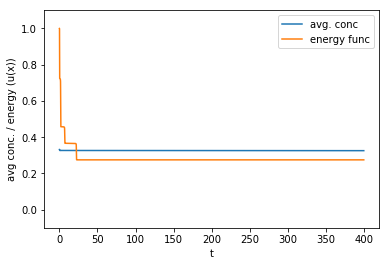

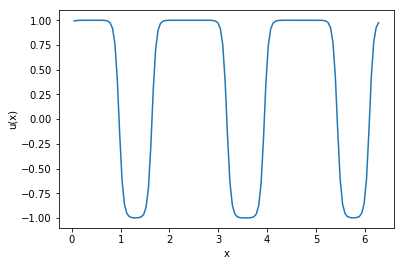

time taken: 170.9670
seed=91403,sigma=0.0020


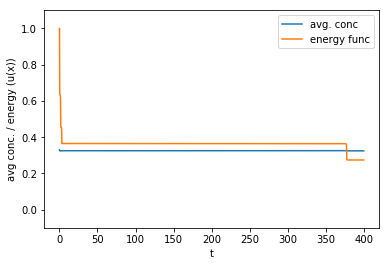

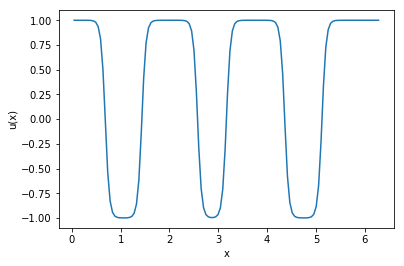

time taken: 170.7730
seed=100000,sigma=0.0020


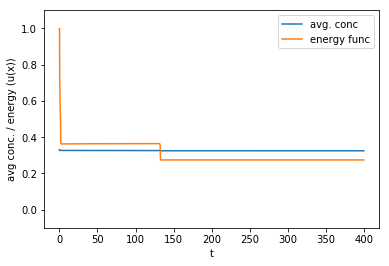

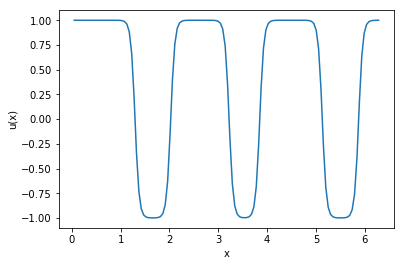

time taken: 167.9720
seed= 3076,sigma=0.0025


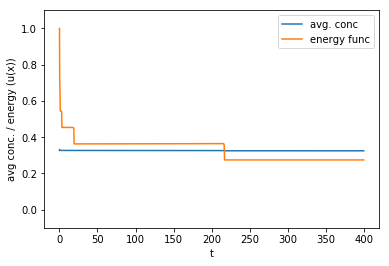

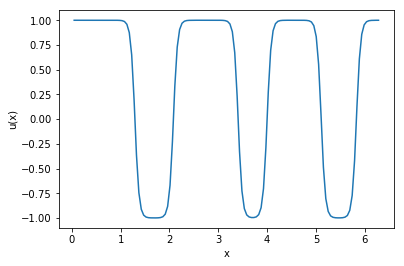

time taken: 171.0050
seed=17145,sigma=0.0025


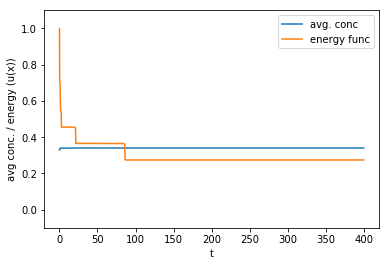

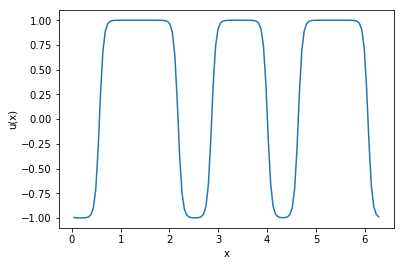

time taken: 170.0700
seed=27193,sigma=0.0025


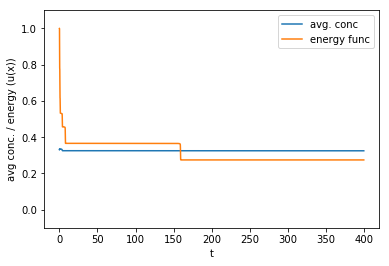

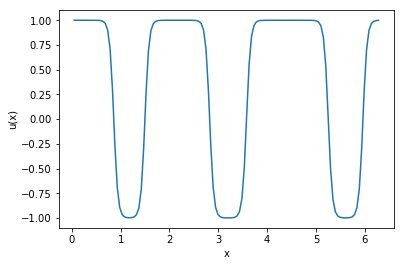

time taken: 167.3160
seed=32927,sigma=0.0025


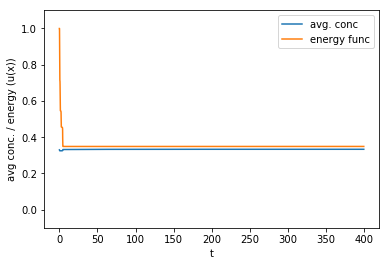

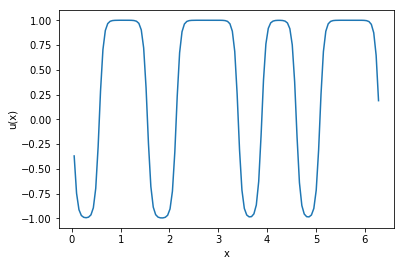

time taken: 168.4390
seed=47329,sigma=0.0025


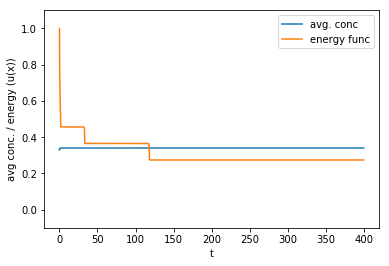

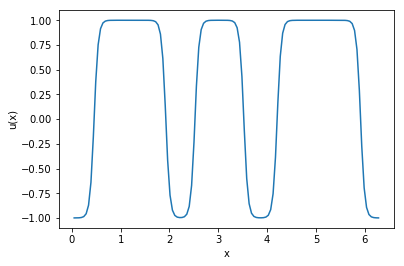

time taken: 171.4230
seed=62877,sigma=0.0025


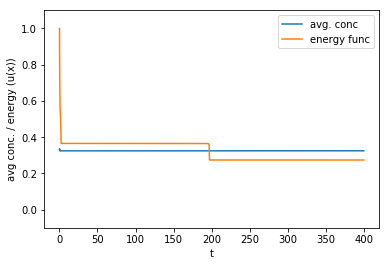

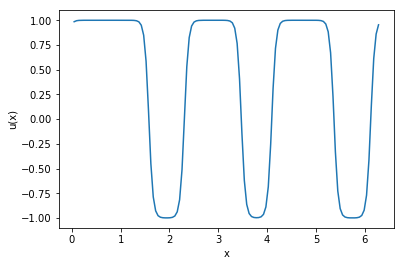

time taken: 168.0610
seed=75313,sigma=0.0025


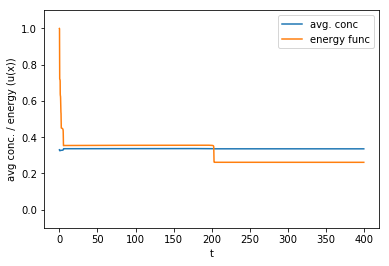

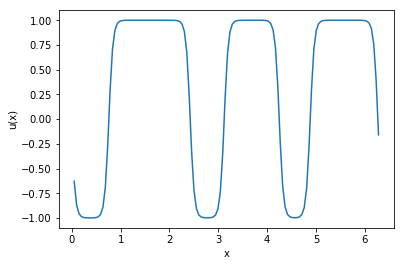

time taken: 170.7210
seed=81602,sigma=0.0025


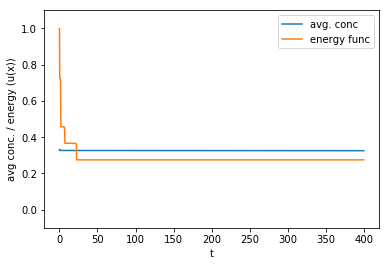

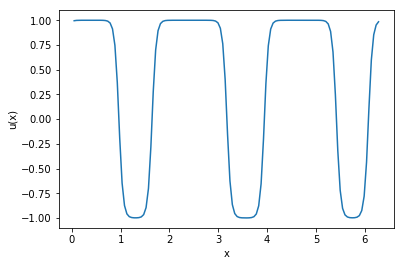

time taken: 168.5230
seed=91403,sigma=0.0025


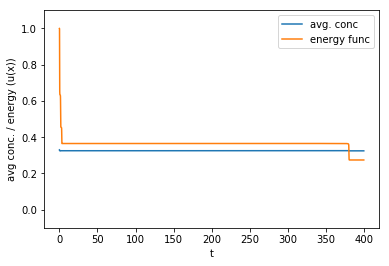

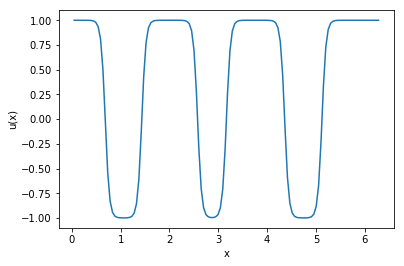

time taken: 168.7450
seed=100000,sigma=0.0025


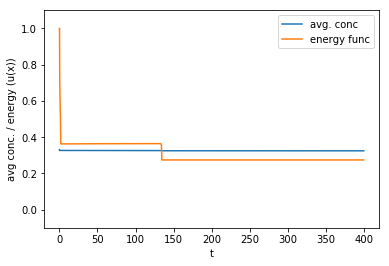

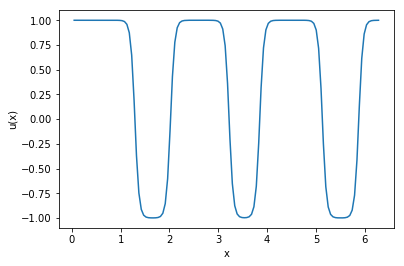

time taken: 171.5310
seed= 3076,sigma=0.0030


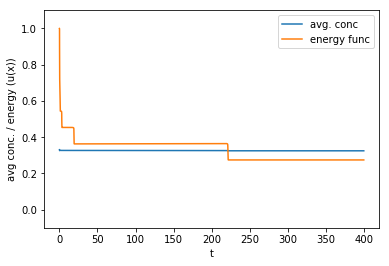

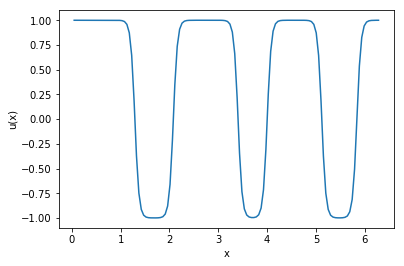

time taken: 167.0230
seed=17145,sigma=0.0030


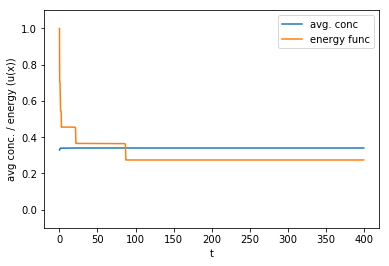

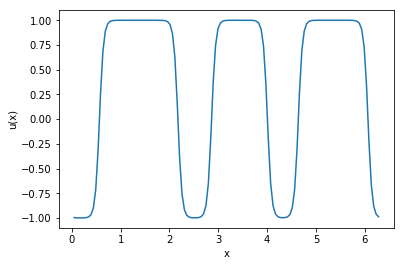

time taken: 171.1710
seed=27193,sigma=0.0030


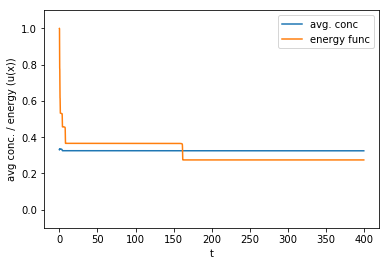

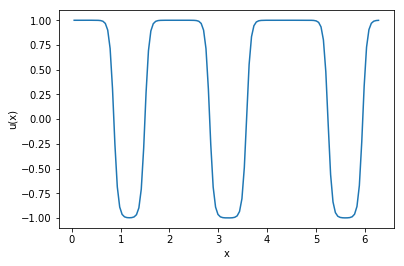

time taken: 167.4680
seed=32927,sigma=0.0030


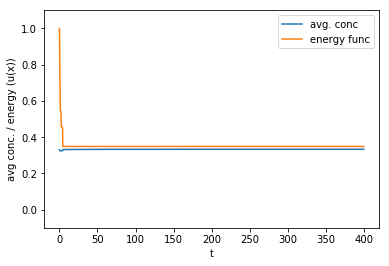

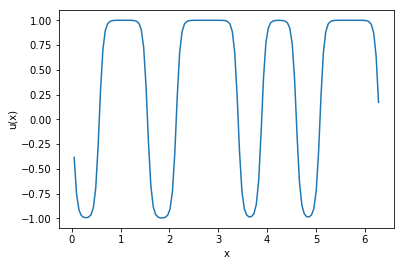

time taken: 171.5760
seed=47329,sigma=0.0030


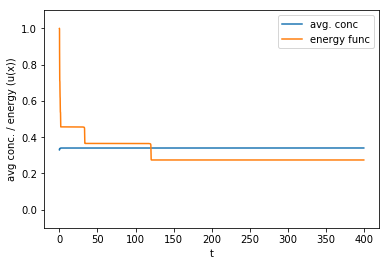

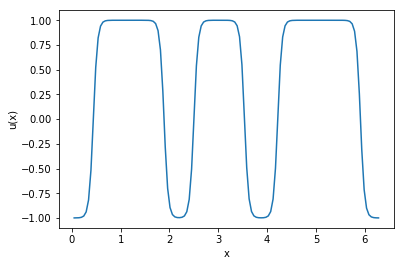

time taken: 170.7580
seed=62877,sigma=0.0030


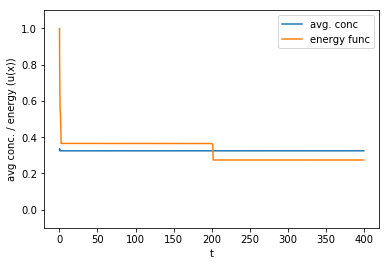

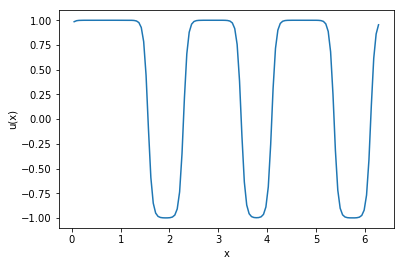

time taken: 167.6540
seed=75313,sigma=0.0030


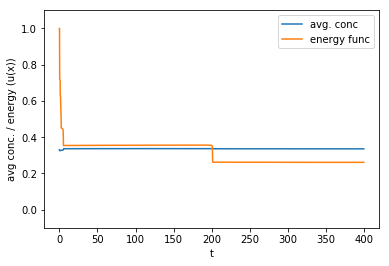

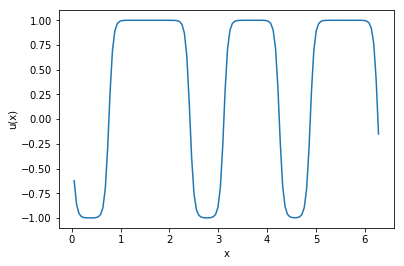

time taken: 173.4370
seed=81602,sigma=0.0030


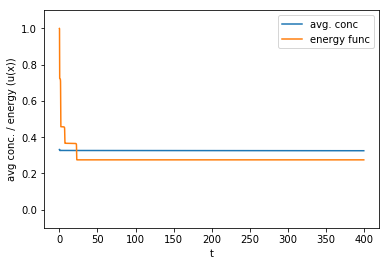

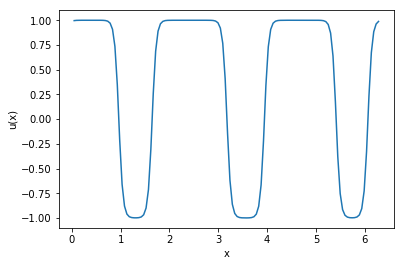

time taken: 180.7970
seed=91403,sigma=0.0030


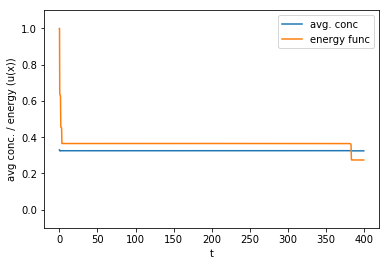

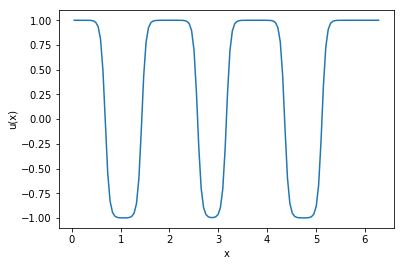

time taken: 184.8550
seed=100000,sigma=0.0030


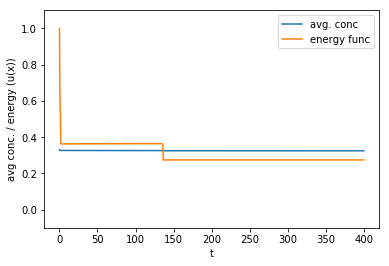

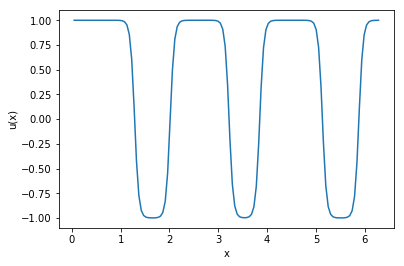

In [145]:
for sigma in sigmas:
    for seed in seeds:
        u, avgConc, energy = etdrk4_1d(Nx,Lx,dt,it,eps,sigma,m,seed,lv)

        print("seed=%5.i,sigma=%.4f" %(seed,sigma))
        # plots
        fig0 = plt.figure()
        ax = plt.gca()
        ax.set_ylim([-.1,1.1])
        plt.xlabel('t')
        plt.ylabel('avg conc. / energy (u(x))')
        plt.plot(t,avgConc)
        plt.plot(t,energy)
        plt.legend(['avg. conc','energy func'])
        plt.show()

        fig1 = plt.figure()
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.plot(x,u)
        plt.show()

Define path of file/run to plot energy, avg. conc. and error.

In [152]:
imgDir = 'imgs/'
tag = ',etdrk4_1D'
path = utils.getPath(Nx,Lx,dt,it,eps,sigma,m,seed,lv,imgDir,tag)

Plot energy and avg. conc. Run checkers to check if they stay within tolerance.

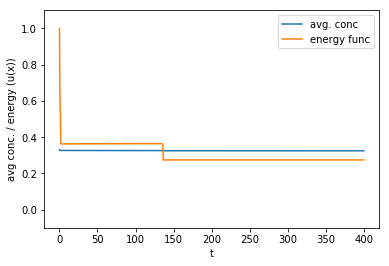

In [153]:
energy = np.loadtxt(path+'/energy.txt')
avgConc = np.loadtxt(path+'/avgConc.txt')

fig2 = plt.figure()
ax = plt.gca()
ax.set_ylim([-.1,1.1])
plt.xlabel('t')
plt.ylabel('avg conc. / energy (u(x))')
plt.plot(t,avgConc)
plt.plot(t,energy)
plt.legend(['avg. conc','energy func'])
plt.show()

checker.energyCheck(energy)
checker.concCheck(avgConc,m)

Plot error. Todo: put error plotting into a function.

gradient of best-fit is -0.006669.


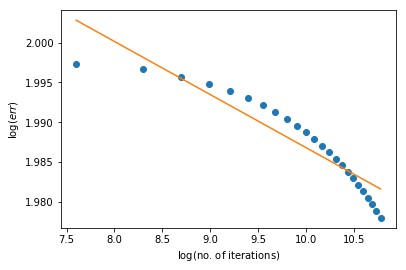

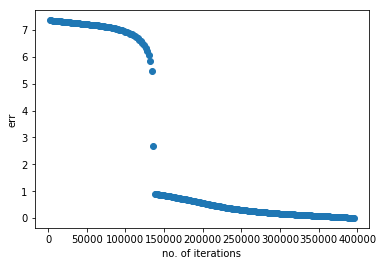

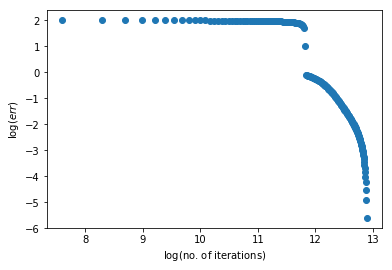

In [163]:
its = np.array(range(0,it,2000))
its = its[1:]

# define range of subinterval.
lowN = 2000
highN = 50000

us = np.zeros((Nx,len(its)))
j = 0
for itx in its:
    us[:,j] = np.loadtxt(path+'/it='+str(itx)+'.txt')
    j += 1
    
uSol = np.loadtxt(path+'/it='+str(its[-1])+'.txt')
uSol = uSol.reshape(Nx,1)
us = us[:,:-1] - uSol
its = its[:-1]

errs = np.sum(abs(us)**2,axis=0)**0.5
#errs = np.linalg.norm(us,axis=0)

low = np.where(its == lowN)[0][0]
high = np.where(its == highN)[0][0]
itsInt = its[low:high]
errsInt = errs[low:high]

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(itsInt),np.log(errsInt))
line = slope*np.log(itsInt)+intercept

print("gradient of best-fit is %.6f." %(slope))

fig3 = plt.figure()
plt.plot(np.log(itsInt),np.log(errsInt),'o')
plt.plot(np.log(itsInt), line,'-')
plt.xlabel(r'$\log($no. of iterations$)$')
plt.ylabel(r'$\log(err)$')
plt.show()

fig4 = plt.figure()
plt.plot(its,errs,'o')
plt.xlabel(r'no. of iterations')
plt.ylabel(r'err')
plt.show()

fig5 = plt.figure()
plt.plot(np.log(its),np.log(errs),'o')
plt.xlabel(r'$\log($no. of iterations$)$')
plt.ylabel(r'$\log(err)$')
plt.show()